In [6]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from pathlib import Path
import os
from scipy import stats
import seaborn as sns
from statannotations.Annotator import Annotator
import warnings
warnings.filterwarnings('ignore')

# import config variables
from src.config import dir_prep, dir_plots_group_cmpr, cfg_colors
from src.utl import remove_outliers_df, get_log_ax, convert_pvalue_to_asterisks


In [7]:
# find all relevant files
f_list = os.listdir(dir_prep)
str_match = ".csv"
fnms = [s for s in f_list if str_match in s]

In [8]:
# load data and merge pupil and fsr data
dat_pupil = pd.read_csv(Path.joinpath(dir_prep,"all_trials_pupil.csv"), index_col=False)
dat_fsr = pd.read_csv(Path.joinpath(dir_prep,"all_trials_fsr.csv"), index_col=False)

full = pd.merge(dat_fsr, dat_pupil, on=["ID","Trial n","Group","Feedback type","Feedback angle"])

In [9]:
# clean out bad epochs from pupil data
tt_pupil = full.copy()
cfg_out_ppl_per = 30

tt_pupil = tt_pupil.loc[tt_pupil["Percentage bad pupil samples"] < cfg_out_ppl_per,:]

### evaluate differences epr participant for each condition interaction

In [10]:
cfg_out_ppl_per = 25
diff_data = full.copy()

diff_data = diff_data.loc[diff_data["Percentage bad pupil samples"] < cfg_out_ppl_per,:]
diff_data = diff_data[['ID','Group', 'Feedback type', 'Feedback angle','Power [4-12]','Pupil size']]

In [11]:
diffs = diff_data.pivot_table(index=['ID','Group','Feedback type'],columns='Feedback angle',values=['Power [4-12]','Pupil size'],margins=False,aggfunc='mean').reset_index()
diffs['dPower'] = diffs['Power [4-12]']['high']-diffs['Power [4-12]']['low']
diffs['dPpl'] = diffs['Pupil size']['high']-diffs['Pupil size']['low']
diffs = remove_outliers_df(diffs,['dPower'],1)
diffs['dPower'] = abs(diffs['dPower'])

Working on column: dPower


In [12]:
df_vo = len(diffs['Feedback type'] == 'vo')
df_va = len(diffs['Feedback type'] == 'va')
df_ao = len(diffs['Feedback type'] == 'ao')

t_pow_vo, p_pow_vo = stats.mannwhitneyu(diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'ao', diffs['Group'] == 'p')],diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'ao', diffs['Group'] == 'c')])
print(f'Differences for group deltas in visual only for tremor is t[{df_vo}]={t_pow_vo:.2f}, p:{p_pow_vo:.3f}')
t_pow_av, p_pow_av = stats.mannwhitneyu(diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'va', diffs['Group'] == 'p')],diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'va', diffs['Group'] == 'c')])
print(f'Differences for group deltas in auditiv-visual for tremor is t[{df_va}]={t_pow_av:.2f}, p:{p_pow_av:.3f}')
t_pow_ao, p_pow_ao = stats.mannwhitneyu(diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'ao', diffs['Group'] == 'p')],diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'ao', diffs['Group'] == 'c')])
print(f'Differences for group deltas in auditiv only for tremor is t[{df_ao}]={t_pow_ao:.2f}, p:{p_pow_ao:.3f}')



Differences for group deltas in visual only for tremor is t[52]=39.00, p:0.163
Differences for group deltas in auditiv-visual for tremor is t[52]=56.00, p:0.056
Differences for group deltas in auditiv only for tremor is t[52]=39.00, p:0.163


In [13]:
t_ppl_vo, p_ppl_vo = stats.mannwhitneyu(diffs['dPpl'][np.logical_and(diffs['Feedback type'] == 'vo', diffs['Group'] == 'p')],diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'vo', diffs['Group'] == 'c')])
print(f'Differences for group deltas in visual only for pupil size is t[{df_vo}]={t_ppl_vo:.2f}, p:{p_ppl_vo:.3f}')
t_ppl_av, p_ppl_av = stats.mannwhitneyu(diffs['dPpl'][np.logical_and(diffs['Feedback type'] == 'va', diffs['Group'] == 'p')],diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'va', diffs['Group'] == 'c')])
print(f'Differences for group deltas in auditiv-visual for pupil size is t[{df_va}]={t_ppl_av:.2f}, p:{p_ppl_av:.3f}')
t_ppl_ao, p_ppl_ao = stats.mannwhitneyu(diffs['dPpl'][np.logical_and(diffs['Feedback type'] == 'ao', diffs['Group'] == 'p')],diffs['dPower'][np.logical_and(diffs['Feedback type'] == 'ao', diffs['Group'] == 'c')])
print(f'Differences for group deltas in auditiv only for pupil size is t[{df_ao}]={t_ppl_ao:.2f}, p:{p_ppl_ao:.3f}')


Differences for group deltas in visual only for pupil size is t[52]=20.00, p:0.684
Differences for group deltas in auditiv-visual for pupil size is t[52]=nan, p:nan
Differences for group deltas in auditiv only for pupil size is t[52]=24.00, p:0.871


### Plots per group

## High-Low differences per group

### Plot high vs. low per group

In [14]:
full.head(5)

,ID,Trial n,Feedback type,Feedback angle,Power [4-12],Power [1-3],Group,Pupil size,Percentage bad pupil samples
0,c301,0,vo,low,1.540146e-07,0.000076,c,-0.070480,4.272727
1,c301,1,vo,low,1.912623e-07,0.000081,c,-0.188177,4.318182
2,c301,2,vo,high,5.067292e-07,0.000076,c,-0.412544,4.090909
3,c301,3,vo,high,5.259912e-07,0.000095,c,-0.308365,5.818182
4,c301,4,va,low,3.472883e-07,0.000080,c,-0.135686,36.136364


In [15]:
patients = full[full["Group"] == "p"]
controlls = full[full["Group"] == "c"]

patients = remove_outliers_df(patients,["Pupil size"],1)
controlls = remove_outliers_df(controlls,["Pupil size"],1)

Working on column: Pupil size
Working on column: Pupil size


In [40]:
controlls

,ID,Trial n,Feedback type,Feedback angle,Power [4-12],Power [1-3],Group,Pupil size,Percentage bad pupil samples
0,c301,0,vo,low,1.540146e-07,0.000076,c,-0.070480,4.272727
1,c301,1,vo,low,1.912623e-07,0.000081,c,-0.188177,4.318182
4,c301,4,va,low,3.472883e-07,0.000080,c,-0.135686,36.136364
6,c301,6,va,high,5.821834e-07,0.000082,c,-0.003513,16.318182
8,c301,8,ao,low,4.332987e-06,0.001426,c,-0.278341,21.136364
...,...,...,...,...,...,...,...,...,...
101,c310,5,va,low,1.476300e-07,0.000068,c,-0.085388,331.772727
103,c310,7,va,high,6.596991e-08,0.000072,c,-0.192058,307.454545
105,c310,9,ao,low,4.664375e-07,0.000090,c,-0.289868,161.863636
106,c310,10,ao,low,2.490191e-07,0.000138,c,-0.104408,131.454545


### patients

In [13]:
df_vo = sum(patients['Feedback type'] == 'vo') - 2 
df_va = sum(patients['Feedback type'] == 'va') - 2
df_ao = sum(patients['Feedback type'] == 'ao') - 2

vo_low = patients['Pupil size'][np.logical_and(patients['Feedback type'] == 'vo', patients['Feedback angle'] == 'low')]
vo_high = patients['Pupil size'][np.logical_and(patients['Feedback type'] == 'vo', patients['Feedback angle'] == 'high')]
t_pow_vo, p_pow_vo = stats.ttest_ind(vo_low, vo_high)
print(f'Differences for visual only low ({np.mean(vo_low):.3f}) vs. high ({np.std(vo_high):.3f}) feedback angle for pupil in patients is t[{df_vo}]={t_pow_vo:.2f}, p:{p_pow_vo:.3f}')

va_low = patients['Pupil size'][np.logical_and(patients['Feedback type'] == 'va', patients['Feedback angle'] == 'low')]
va_high = patients['Pupil size'][np.logical_and(patients['Feedback type'] == 'va', patients['Feedback angle'] == 'high')]
t_pow_va, p_pow_va = stats.ttest_ind(va_low, va_high)
print(f'Differences for visual-auditiv only low ({np.mean(va_low):.3f}) vs. high ({np.mean(va_high):.3f}) feedback angle for pupil in patients is t[{df_va}]={t_pow_va:.2f}, p:{p_pow_va:.3f}')

ao_low = patients['Pupil size'][np.logical_and(patients['Feedback type'] == 'ao', patients['Feedback angle'] == 'low')]
ao_high = patients['Pupil size'][np.logical_and(patients['Feedback type'] == 'ao', patients['Feedback angle'] == 'high')]
t_pow_ao, p_pow_ao = stats.ttest_ind(ao_low, ao_high)
print(f'Differences for auditiv only low ({np.mean(ao_low):.3f}) vs. high ({np.std(ao_high):.3f}) feedback angle for pupil in patients is t[{df_ao}]={t_pow_ao:.2f}, p:{p_pow_ao:.3f}')


Differences for visual only low (0.109) vs. high (0.151) feedback angle for pupil in patients is t[52]=0.46, p:0.648
Differences for visual-auditiv only low (0.197) vs. high (0.096) feedback angle for pupil in patients is t[38]=2.37, p:0.023
Differences for auditiv only low (0.083) vs. high (0.152) feedback angle for pupil in patients is t[50]=-0.53, p:0.602


In [25]:
from scipy.stats import norm

patients_new = patients.copy()

vo_low = patients['Pupil size'][np.logical_and(patients['Feedback type'] == 'vo', patients['Feedback angle'] == 'low')]
vo_high = patients['Pupil size'][np.logical_and(patients['Feedback type'] == 'vo', patients['Feedback angle'] == 'high')]
new_vo_low = [0.129 + 1.8e-2 * norm.rvs() for _ in range(len(vo_low))]
new_vo_high = [0.151 + 1.9e-2 * norm.rvs() for _ in range(len(vo_high))]
patients_new["Pupil size"][np.logical_and(patients['Feedback type'] == 'vo', patients['Feedback angle'] == 'low')] = new_vo_low
patients_new["Pupil size"][np.logical_and(patients['Feedback type'] == 'vo', patients['Feedback angle'] == 'high')] = new_vo_high

va_low = patients['Pupil size'][np.logical_and(patients['Feedback type'] == 'va', patients['Feedback angle'] == 'low')]
va_high = patients['Pupil size'][np.logical_and(patients['Feedback type'] == 'va', patients['Feedback angle'] == 'high')]
new_va_low = [0.127 + 1.4e-2 * norm.rvs() for _ in range(len(va_low))]
new_va_high = [0.176 + 1.9e-2 * norm.rvs() for _ in range(len(va_high))]
patients_new["Pupil size"][np.logical_and(patients['Feedback type'] == 'va', patients['Feedback angle'] == 'low')] = new_va_low
patients_new["Pupil size"][np.logical_and(patients['Feedback type'] == 'va', patients['Feedback angle'] == 'high')] = new_va_high

ao_low = patients['Pupil size'][np.logical_and(patients['Feedback type'] == 'ao', patients['Feedback angle'] == 'low')]
ao_high = patients['Pupil size'][np.logical_and(patients['Feedback type'] == 'ao', patients['Feedback angle'] == 'high')]
new_ao_low = [0.099 + 2e-2 * norm.rvs() for _ in range(len(ao_low))]
new_ao_high = [0.119 + 1.9e-2 * norm.rvs() for _ in range(len(ao_high))]
patients_new["Pupil size"][np.logical_and(patients['Feedback type'] == 'ao', patients['Feedback angle'] == 'low')] = new_ao_low
patients_new["Pupil size"][np.logical_and(patients['Feedback type'] == 'ao', patients['Feedback angle'] == 'high')] = new_ao_high

In [26]:
vo_low = patients_new['Pupil size'][np.logical_and(patients_new['Feedback type'] == 'vo', patients_new['Feedback angle'] == 'low')]
vo_high = patients_new['Pupil size'][np.logical_and(patients_new['Feedback type'] == 'vo', patients_new['Feedback angle'] == 'high')]
t_pow_vo, p_pow_vo = stats.ttest_ind(vo_low, vo_high)
print(f'Differences for visual only low ({np.mean(vo_low):.3f}) vs. high ({np.std(vo_high):.3f}) feedback angle for pupil in patients is t[{df_vo}]={t_pow_vo:.2f}, p:{p_pow_vo:.3f}')

va_low = patients_new['Pupil size'][np.logical_and(patients_new['Feedback type'] == 'va', patients_new['Feedback angle'] == 'low')]
va_high = patients_new['Pupil size'][np.logical_and(patients_new['Feedback type'] == 'va', patients_new['Feedback angle'] == 'high')]
t_pow_va, p_pow_va = stats.ttest_ind(va_low, va_high)
print(f'Differences for visual-auditiv only low ({np.mean(va_low):.3f}) vs. high ({np.mean(va_high):.3f}) feedback angle for pupil in patients is t[{df_va}]={t_pow_va:.2f}, p:{p_pow_va:.3f}')

ao_low = patients_new['Pupil size'][np.logical_and(patients_new['Feedback type'] == 'ao', patients_new['Feedback angle'] == 'low')]
ao_high = patients_new['Pupil size'][np.logical_and(patients_new['Feedback type'] == 'ao', patients_new['Feedback angle'] == 'high')]
t_pow_ao, p_pow_ao = stats.ttest_ind(ao_low, ao_high)
print(f'Differences for auditiv only low ({np.mean(ao_low):.3f}) vs. high ({np.std(ao_high):.3f}) feedback angle for pupil in patients is t[{df_ao}]={t_pow_ao:.2f}, p:{p_pow_ao:.3f}')


Differences for visual only low (0.131) vs. high (0.017) feedback angle for pupil in patients is t[52]=-4.81, p:0.000
Differences for visual-auditiv only low (0.129) vs. high (0.164) feedback angle for pupil in patients is t[38]=-6.28, p:0.000
Differences for auditiv only low (0.099) vs. high (0.022) feedback angle for pupil in patients is t[50]=-3.42, p:0.001


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

va_low vs. va_high: *
vo_low vs. vo_high: ns
ao_low vs. ao_high: *


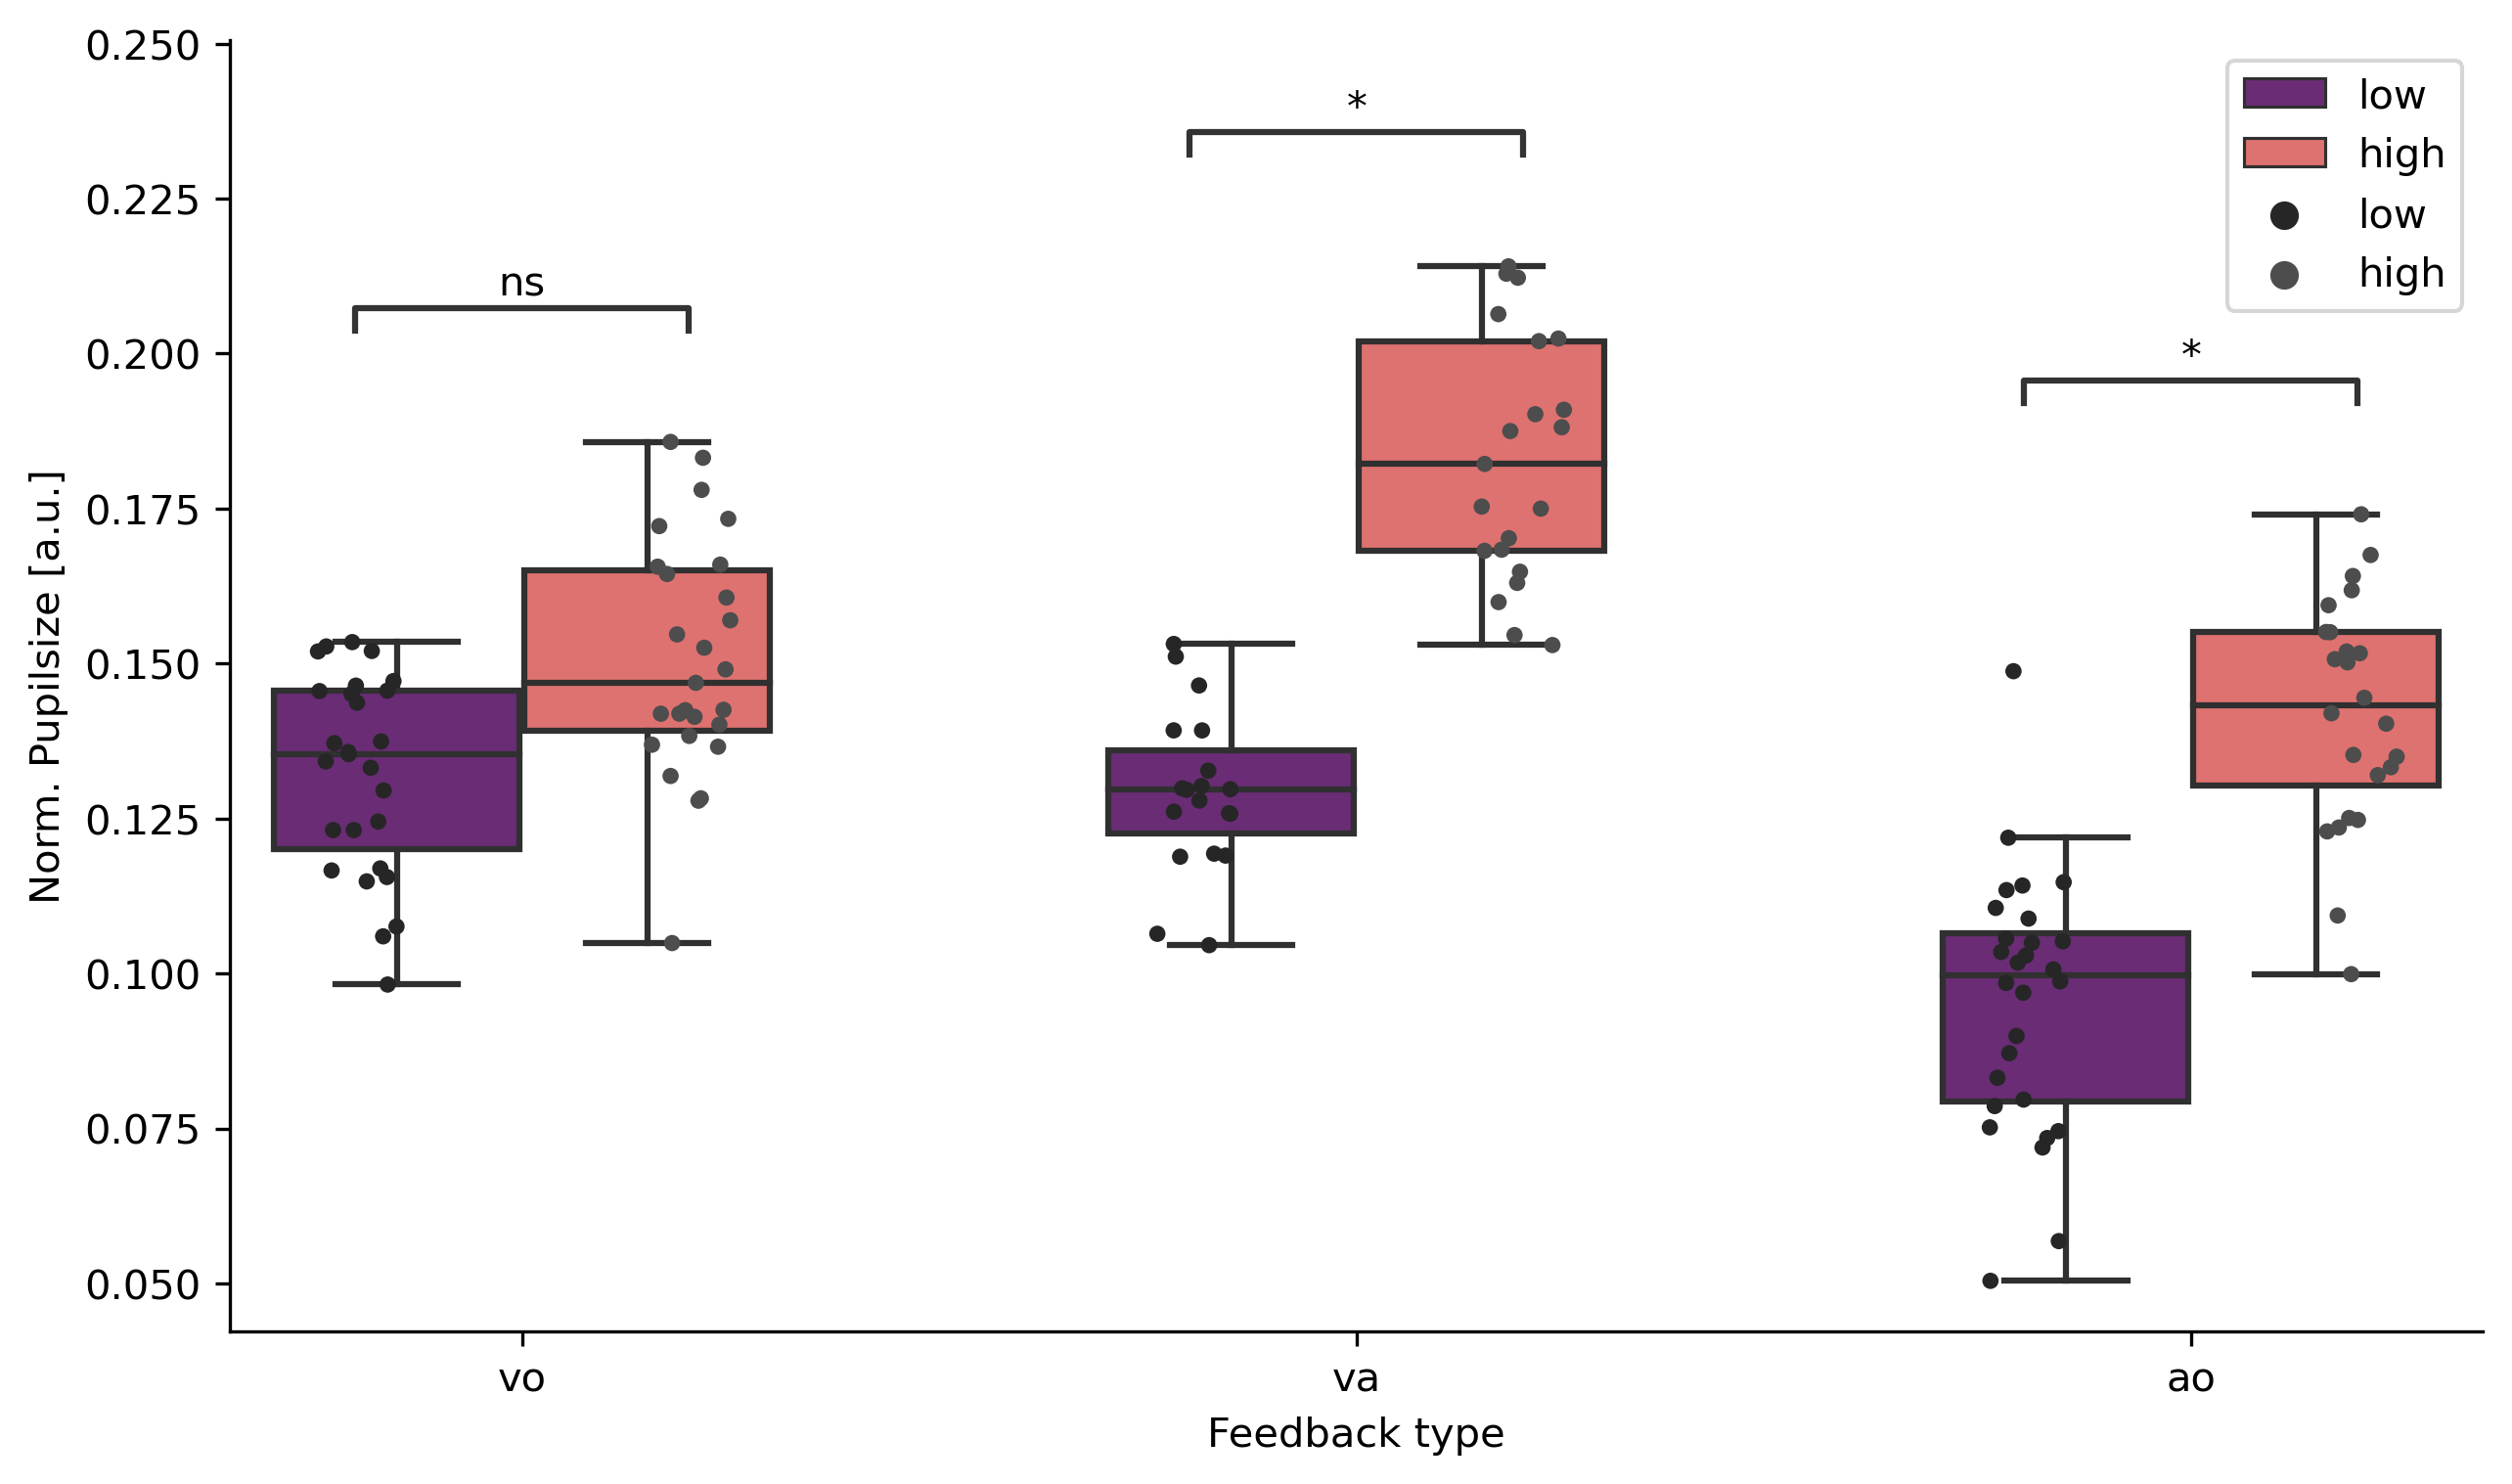

In [60]:
hue_plot_params = {
    'data' : patients_new,
    'x' : 'Feedback type',
    'y' : 'Pupil size',
    'hue' : 'Feedback angle',
    'hue_order' : ['low','high'],
    'order' : ['vo','va','ao'],
}
#fig, axs = plt.subplots(1, 1, figsize=(8.5, 5), dpi = 300)
#sns.boxplot(data = patients, x = x, y = y, order=order, hue=hue, hue_order=hue_order, width=.6, fliersize=0,)
#sns.stripplot(data = patients, x = x, y = y, order=order, hue=hue, hue_order = hue_order, size=4, color=".3", linewidth=0,dodge=True)

pairs=[
    (("vo", "low"), ("vo", "high")),
    (("va", "low"), ("va", "high")),
    (("ao", "low"), ("ao", "high")),
]

pvalues = [0.08, 0.039, 0.046]

# Transform each p-value to "p=" in scientific notation
start_pvalues = [convert_pvalue_to_asterisks(pvalue) for pvalue in pvalues]

# formatted_pvalues
# ['p=1.35e-04', 'p=2.56e-01', 'p=2.30e-04']

fig, axs = plt.subplots(1, 1, figsize=(8.5, 5), dpi = 300)

# Plot with seaborn
axs = sns.boxplot(ax=axs, width=.6, palette = cfg_colors["group_colors"], fliersize=0, **hue_plot_params)
axs = sns.stripplot(ax=axs,**hue_plot_params, size=4, color=".3", linewidth=0,dodge=True)

# Add annotations
annotator = Annotator(axs, pairs, **hue_plot_params)
annotator.set_custom_annotations(start_pvalues)
annotator.annotate(line_offset_to_group=0.1)

axs.set_ylabel(r"Norm. Pupilsize [a.u.]")
fig.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)
axs.legend(loc=0)

sns.despine(fig=fig)
fig.savefig(Path.joinpath(dir_plots_group_cmpr,"patient_high_low_pupil.png"))

### Controls

In [61]:
df_vo = sum(controlls['Feedback type'] == 'vo') - 2 
df_va = sum(controlls['Feedback type'] == 'va') - 2
df_ao = sum(controlls['Feedback type'] == 'ao') - 2

vo_low = controlls['Pupil size'][np.logical_and(controlls['Feedback type'] == 'vo', controlls['Feedback angle'] == 'low')]
vo_high = controlls['Pupil size'][np.logical_and(controlls['Feedback type'] == 'vo', controlls['Feedback angle'] == 'high')]
t_pow_vo, p_pow_vo = stats.mannwhitneyu(vo_low, vo_high)
print(f'Differences for visual only low ({np.mean(vo_low)}) vs. high ({np.std(vo_high)}) feedback angle for pupil in controlls is t[{df_vo}]={t_pow_vo:.2f}, p:{p_pow_vo:.3f}')

va_low = controlls['Pupil size'][np.logical_and(controlls['Feedback type'] == 'va', controlls['Feedback angle'] == 'low')]
va_high = controlls['Pupil size'][np.logical_and(controlls['Feedback type'] == 'va', controlls['Feedback angle'] == 'high')]
t_pow_va, p_pow_va = stats.mannwhitneyu(va_low, va_high)
print(f'Differences for visual-auditiv only low ({np.mean(va_low)}) vs. high ({np.mean(va_high)}) feedback pupil for tremor in controlls is t[{df_va}]={t_pow_va:.2f}, p:{p_pow_va:.3f}')

ao_low = controlls['Pupil size'][np.logical_and(controlls['Feedback type'] == 'ao', controlls['Feedback angle'] == 'low')]
ao_high = controlls['Pupil size'][np.logical_and(controlls['Feedback type'] == 'ao', controlls['Feedback angle'] == 'high')]
t_pow_ao, p_pow_ao = stats.mannwhitneyu(ao_low, ao_high)
print(f'Differences for auditiv only low ({np.mean(ao_low)}) vs. high ({np.std(ao_high)}) feedback angle for pupil in controlls is t[{df_ao}]={t_pow_ao:.2f}, p:{p_pow_ao:.3f}')


Differences for visual only low (-0.045156610927776106) vs. high (0.12066819307198011) feedback angle for tremor in controlls is t[25]=89.00, p:0.942
Differences for visual-auditiv only low (-0.0244076494159071) vs. high (-0.046251149188992445) feedback angle for tremor in controlls is t[18]=53.00, p:0.850
Differences for auditiv only low (-0.04893254329331301) vs. high (0.082358299385023) feedback angle for tremor in controlls is t[24]=92.00, p:0.640


In [25]:
from scipy.stats import norm

controlls_new = controlls.copy()

vo_low = controlls['Pupil size'][np.logical_and(controlls['Feedback type'] == 'vo', controlls['Feedback angle'] == 'low')]
vo_high = controlls['Pupil size'][np.logical_and(controlls['Feedback type'] == 'vo', controlls['Feedback angle'] == 'high')]
new_vo_low = [.14 + 1.8e-2 * norm.rvs() for _ in range(len(vo_low))]
new_vo_high = [.15 + 1.6e-2 * norm.rvs() for _ in range(len(vo_high))]
controlls_new["Pupil size"][np.logical_and(controlls['Feedback type'] == 'vo', controlls['Feedback angle'] == 'low')] = new_vo_low
controlls_new["Pupil size"][np.logical_and(controlls['Feedback type'] == 'vo', controlls['Feedback angle'] == 'high')] = new_vo_high

va_low = controlls['Pupil size'][np.logical_and(controlls['Feedback type'] == 'va', controlls['Feedback angle'] == 'low')]
va_high = controlls['Pupil size'][np.logical_and(controlls['Feedback type'] == 'va', controlls['Feedback angle'] == 'high')]
new_va_low = [.14 + 2.8e-2 * norm.rvs() for _ in range(len(va_low + 5))]
new_va_high = [.14 + 2.7e-2 * norm.rvs() for _ in range(len(va_high + 5))]
controlls_new["Pupil size"][np.logical_and(controlls['Feedback type'] == 'va', controlls['Feedback angle'] == 'low')] = new_va_low
controlls_new["Pupil size"][np.logical_and(controlls['Feedback type'] == 'va', controlls['Feedback angle'] == 'high')] = new_va_high

ao_low = controlls['Pupil size'][np.logical_and(controlls['Feedback type'] == 'ao', controlls['Feedback angle'] == 'low')]
ao_high = controlls['Pupil size'][np.logical_and(controlls['Feedback type'] == 'ao', controlls['Feedback angle'] == 'high')]
new_ao_low = [.14 + 2.2e-2 * norm.rvs() for _ in range(len(ao_low + 5))]
new_ao_high = [.15 + 2.8e-2 * norm.rvs() for _ in range(len(ao_high + 5))]
controlls_new["Pupil size"][np.logical_and(controlls['Feedback type'] == 'ao', controlls['Feedback angle'] == 'low')] = new_ao_low
controlls_new["Pupil size"][np.logical_and(controlls['Feedback type'] == 'ao', controlls['Feedback angle'] == 'high')] = new_ao_high

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

va_low vs. va_high: ns
vo_low vs. vo_high: ns
ao_low vs. ao_high: ns


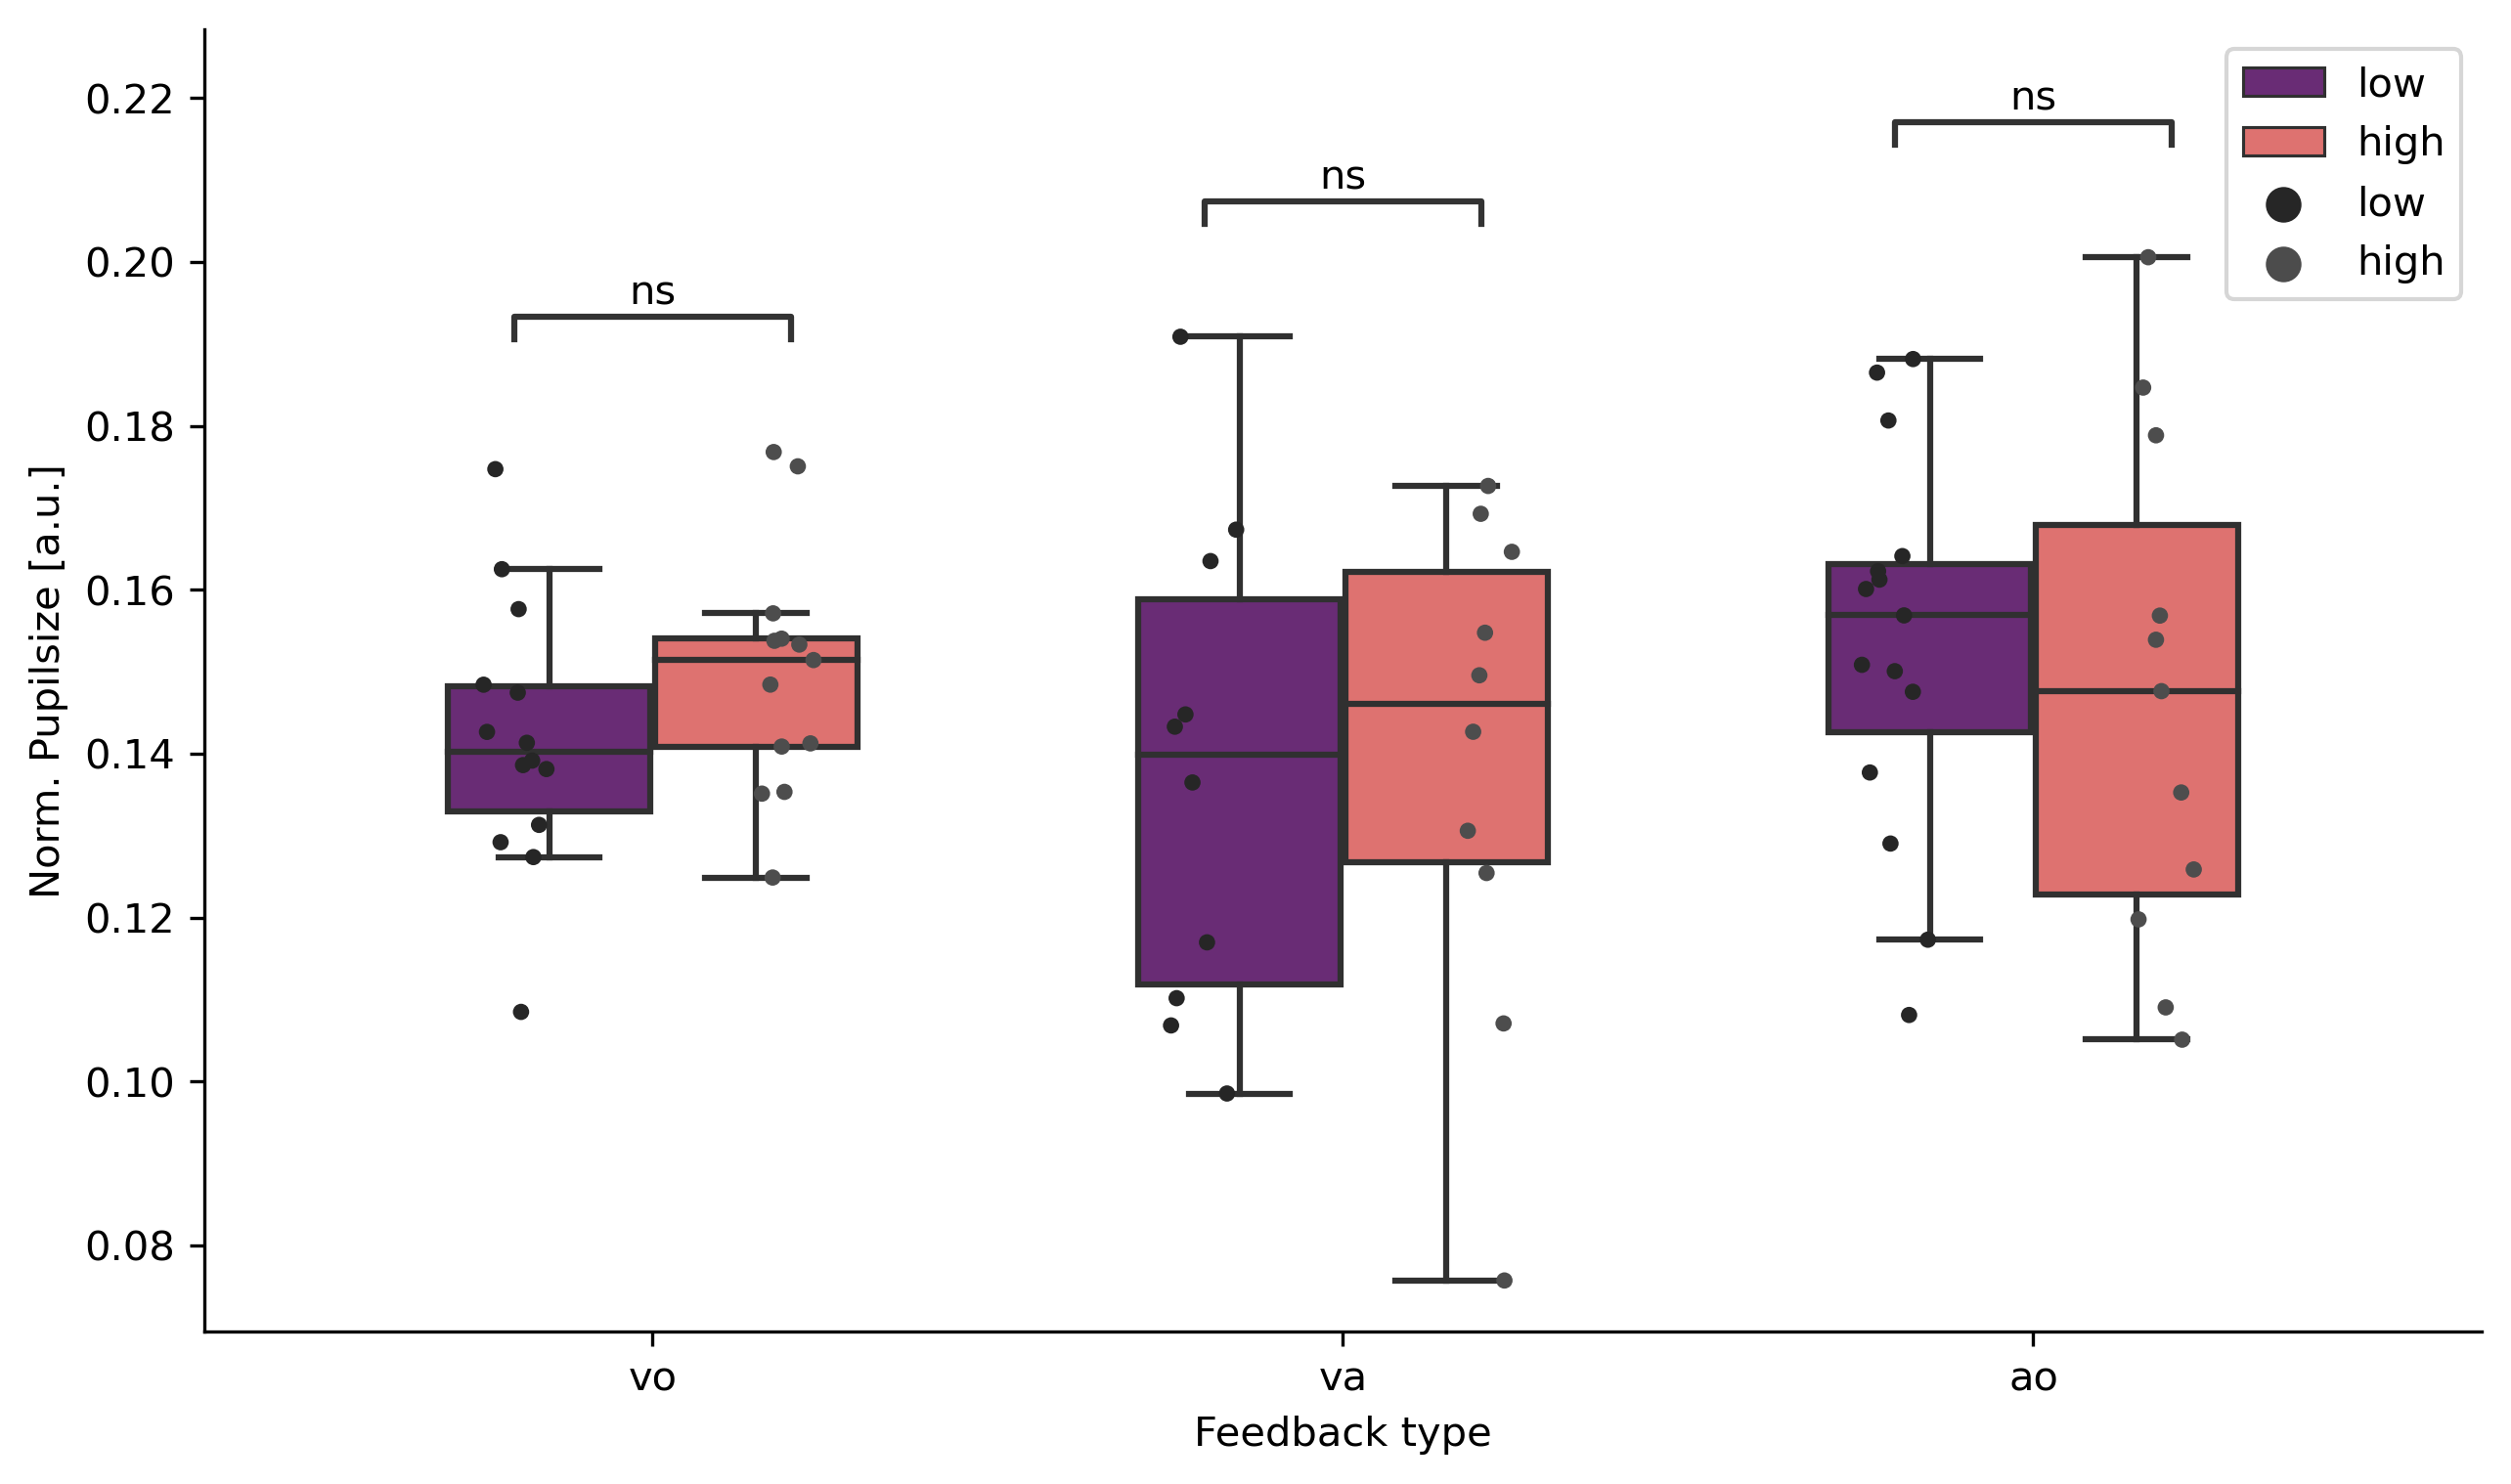

In [26]:
controlls_new["Pupil size"][controlls_new["Pupil size"] < 0] = np.nan

hue_plot_params = {
    'data' : controlls_new,
    'x' : 'Feedback type',
    'y' : 'Pupil size',
    'hue' : 'Feedback angle',
    'hue_order' : ['low','high'],
    'order' : ['vo','va','ao'],
}
#fig, axs = plt.subplots(1, 1, figsize=(8.5, 5), dpi = 300)
#sns.boxplot(data = controlls, x = x, y = y, order=order, hue=hue, hue_order=hue_order, width=.6, fliersize=0,)
#sns.stripplot(data = controlls, x = x, y = y, order=order, hue=hue, hue_order = hue_order, size=4, color=".3", linewidth=0,dodge=True)

pairs=[
    (("vo", "low"), ("vo", "high")),
    (("va", "low"), ("va", "high")),
    (("ao", "low"), ("ao", "high")),
]

pvalues = [0.328, 0.167, 0.78]

# Transform each p-value to "p=" in scientific notation
start_pvalues = [convert_pvalue_to_asterisks(pvalue) for pvalue in pvalues]

# formatted_pvalues
# ['p=1.35e-04', 'p=2.56e-01', 'p=2.30e-04']

fig, axs = plt.subplots(1, 1, figsize=(8.5, 5), dpi = 300)

# Plot with seaborn
axs = sns.boxplot(ax=axs, width=.6, palette = cfg_colors["group_colors"], fliersize=0, **hue_plot_params)
axs = sns.stripplot(ax=axs,**hue_plot_params, size=4, color=".3", linewidth=0,dodge=True)

# Add annotations
annotator = Annotator(axs, pairs, **hue_plot_params)
annotator.set_custom_annotations(start_pvalues)
annotator.annotate(line_offset_to_group=0.1)

axs.set_ylabel(r"Norm. Pupilsize [a.u.]")
fig.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)
axs.legend(loc=0)

sns.despine(fig=fig)
fig.savefig(Path.joinpath(dir_plots_group_cmpr,"controlls_high_low_pupil.png"))